# Simulation using CTA IRFs

- Intrinsic spectrum assumed to be extrapolation of the Fermi-LAT spectrum (showing example of `gammapy.catalog`)
- Add EBL absorpsion
- Simulated CTA DL4 data

In [30]:
%matplotlib inline

In [31]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation
from gammapy.datasets import MapDataset

from gammapy.catalog import SourceCatalog4FGL

## Use gammapy.catalog to find the Fermi spectrum
- see https://docs.gammapy.org/0.19/tutorials/api/catalog.html for details

In [32]:
catalog = SourceCatalog4FGL()
catalog.description

'LAT 8-year point source catalog'

In [33]:
## explore some other catalogs

In [34]:
#catalog.table

In [35]:
source = catalog["PKS 2155-304"]

In [36]:
print(source)


*** Basic info ***

Catalog row index (zero-based) : 6206
Source name          : 4FGL J2158.8-3013
Extended name        :                   
Associations     : PKS 2155-304, PKS 2155-304, 3FGL J2158.8-3013, 3FHL J2158.8-3013, 2AGL J2157-3015, 3EG J2158-3023, EGR J2200-3015
ASSOC_PROB_BAY   : 1.000
ASSOC_PROB_LR    : 1.000
Class1           : bll  
Class2           :           
TeVCat flag      : P

*** Other info ***

Significance (100 MeV - 1 TeV)   : 238.600
Npred                            : 17766.5

Other flags          : 0

*** Position info ***

RA                   : 329.714 deg
DEC                  : -30.225 deg
GLON                 : 17.731 deg
GLAT                 : -52.243 deg

Semimajor (68%)      : 0.0049 deg
Semiminor (68%)      : 0.0049 deg
Position angle (68%) : -22.82 deg
Semimajor (95%)      : 0.0079 deg
Semiminor (95%)      : 0.0079 deg
Position angle (95%) : -22.82 deg
ROI number           : 932

*** Spectral info ***

Spectrum type                                 :

In [37]:
source.row_index

6206

In [38]:
catalog.table[6206]

Source_Name,DataRelease,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,LP_EPeak,Unc_LP_EPeak,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_IndexS,Unc_PLEC_IndexS,PLEC_ExpfactorS,Unc_PLEC_ExpfactorS,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,PLEC_EPeak,Unc_PLEC_EPeak,Npred,Flux_Band,Unc_Flux_Band,nuFnu_Band,Sqrt_TS_Band,Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History,Unc_Flux_History,Sqrt_TS_History,ASSOC_4FGL,ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_Counterpart,Flags
,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,,MeV,1 / (s cm2),1 / (s cm2),erg / (s cm2),erg / (s cm2),,1 / (MeV s cm2),1 / (MeV s cm2),,,1 / (MeV s cm2),1 / (MeV s cm2),,,,,,MeV,MeV,1 / (MeV s cm2),1 / (MeV s cm2),,,,,,,,MeV,MeV,,1 / (s cm2),1 / (s cm2),erg / (s cm2),,,,,,1 / (s cm2),1 / (s cm2),s,s,1 / (s cm2),1 / (s cm2),,,,,,,,,,,,,,,,deg,deg,deg,
bytes18,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bytes18,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[8],"float32[8,2]",float32[8],float32[8],float32,float32,float32,float32,float32,float32,float64,float32,float32[12],"float32[12,2]",float32[12],bytes18,bytes18,bytes18,bytes18,bytes18,bytes18,bytes1,bytes30,bytes5,bytes10,bytes28,bytes28,float32,float32,float64,float64,float32,int16
4FGL J2158.8-3013,1,329.7141,-30.2251,17.7308,-52.2434,0.0049,0.0049,-22.820,0.0079,0.0079,-22.820,932,,238.600,1146.89,2.0042e-08,2.1901e-10,2.1198e-10,3.0064e-12,LogParabola,1.2817e-11,1.2711e-13,1.8496,0.0067,1.3413e-11,1.4609e-13,1.7672,0.0088,0.0406,0.0038,7.781,20188.0,4064.4,1.3032e-11,1.3417e-13,1.7755,0.0095,0.02278,0.00228,0.6667,--,8.477,23880.7,2501.1,17766.49,9.7760186e-08 .. 1.3523291e-10,-3.2013567e-08 .. 1.75857e-11,1.5950439e-11 .. 2.203654e-11,2.961729 .. 29.674353,745.3666,0.2522,0.0546,99.613,1.7118121e-07,3.9726333e-09,255223712.0,31332582.0,1.7118121e-07 .. 8.565562e-08,-3.9726333e-09 .. 3.2098462e-09,99.61309 .. 59.28383,4FGL J2158.8-3013,3FGL J2158.8-3013,3FHL J2158.8-3013,2AGL J2157-3015,3EG J2158-3023,EGR J2200-3015,P,PKS 2155-304,bll,,PKS 2155-304,,1.0000,0.9997,329.7169,-30.2256,0.00000,0


In [39]:
source.position

<SkyCoord (ICRS): (ra, dec) in deg
    (329.71411133, -30.22509956)>

In [40]:
sky_model = source.sky_model()

In [41]:
print(sky_model)

SkyModel

  Name                      : 4FGL J2158.8-3013
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.34e-11   +/- 1.5e-13 1 / (MeV s cm2)
    reference             (frozen):   1146.894       MeV         
    alpha                         :      1.767   +/-    0.01             
    beta                          :      0.041   +/-    0.00             
    lon_0                         :    329.714   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         




<Axes: xlabel='Energy [$\\mathrm{MeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

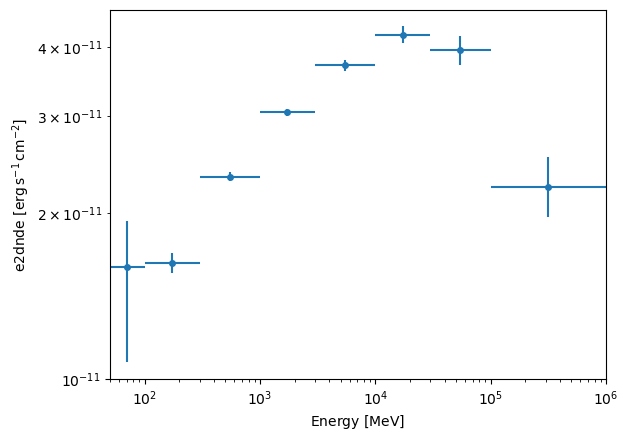

In [42]:
source.flux_points.plot(sed_type="e2dnde")

## Now, simulate for CTA using the above model

### Create a fake observation defining observation conditions

In [59]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/North_z20_50h/irf_file.fits"
)

/tmp/ipykernel_136641/2226499357.py:2: GammapyDeprecationWarning: The load_cta_irfs function is deprecated and may be removed in a future version.
        Use load_irf_dict_from_file instead.
  irfs = load_cta_irfs(


FileNotFoundError: [Errno 2] No such file or directory: '/home/born-again/Documents/GitHub/gammapy/gammapy-datasets/1.1/cta-1dc/caldb/data/cta/1dc/bcf/North_z20_50h/irf_file.fits'

In [44]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 2.0 * u.hr
pointing = source.position

In [45]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=source.position,
    binsz=0.02,
    width=(3, 3),
    frame="icrs",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

### Define model to simulate the data

- intrinsic model from the 4FGL
- EBL model (see: https://docs.gammapy.org/0.19/modeling/gallery/spectral/plot_absorbed.html?highlight=ebl)

In [46]:
int_model = sky_model.spectral_model
print(int_model)

LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 1.3413e-11 MeV-1 s-1 cm-2 ... nan  False    True     
spectral reference 1.1469e+03            MeV ... nan   True   False     
spectral     alpha 1.7672e+00                ... nan  False   False     
spectral      beta 4.0590e-02                ... nan  False   False     


In [47]:
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

In [48]:
spectral_model = ebl * int_model
spatial_model = sky_model.spatial_model
model_simu = SkyModel(spectral_model=spectral_model, 
                      spatial_model=spatial_model,
                      name="model-simu")

In [49]:
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

In [50]:
models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.116                   
    amplitude                     :   1.34e-11   +/- 1.5e-13 1 / (MeV s cm2)
    reference             (frozen):   1146.894       MeV         
    alpha                         :      1.767   +/-    0.01             
    beta                          :      0.041   +/-    0.00             
    lon_0                         :    329.714   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectra

### Now, perform a simulation

In [51]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.08
	duration          : 7200.00 s
	pointing (icrs)   : 329.7 deg, -30.2 deg

	deadtime fraction : 0.0%



/home/born-again/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [52]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 0 
  Total background counts         : 52917.67
  Total excess counts             : -52917.67

  Predicted counts                : 52917.67
  Predicted background counts     : 52917.67
  Predicted excess counts         : nan

  Exposure min                    : 4.64e+07 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [53]:
#Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 55488 
  Total background counts         : 52917.67
  Total excess counts             : 2570.33

  Predicted counts                : 55655.39
  Predicted background counts     : 52917.67
  Predicted excess counts         : 2737.72

  Exposure min                    : 4.64e+07 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 152646.00

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
   

In [54]:
dataset.excess.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [55]:
dataset.counts

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (150, 150, 9)
	ndim  : 3
	unit  : 
	dtype : int64

<WCSAxes: >

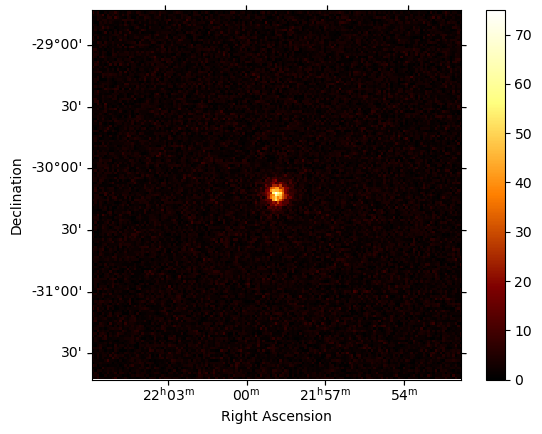

In [56]:
dataset.counts.sum_over_axes().plot(add_cbar=True)

In [57]:
dataset.counts.get_image_by_coord({"energy": "5 TeV"})

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (150, 150)
	ndim  : 2
	unit  : 
	dtype : int64

In [58]:
dataset.write("pks2155-simulated.fits.gz", overwrite=True)